In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, auc, roc_auc_score, precision_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import scikitplot as skplt
import warnings
from scipy import stats
import time


In [2]:
# Load your dataset
# Replace this with the actual path to your dataset
data = pd.read_csv('cowrie_honeypot_ml_dataset.csv')


In [4]:
print("Missing values in the dataset:")
print(data.isnull().sum())

Missing values in the dataset:
src_ip                0
username_auth        17
password_auth       811
input_cmd         17147
timestamp_auth        0
severity              0
country               0
dtype: int64


In [5]:
# Fill empty fields with 0 
data['input_cmd'] = data['input_cmd'].fillna('N/A')
data['username_auth'] = data['username_auth'].fillna('N/A')
data['password_auth'] = data['password_auth'].fillna('N/A')


In [6]:
# Define the features and target variable
X = data[['input_cmd', 'country', 'username_auth', 'password_auth']]
y = data['severity'] 

In [7]:
data

,src_ip,username_auth,password_auth,input_cmd,timestamp_auth,severity,country
0,82.66.220.36,root,261081,"echo -e ""\x6F\x6B""",2023-04-14T18:50:39.577367Z,1,France
1,91.200.114.76,guest,guest,cd /dev/shm; cat .s || cp /bin/echo .s; /bin/b...,2023-04-19T00:03:31.332800Z,0,Ukraine
2,223.13.70.41,root,root,enable,2023-04-15T21:58:50.872869Z,1,China
3,82.66.220.36,root,19840906,"echo -e ""\x6F\x6B""",2023-04-14T19:46:38.628513Z,1,France
4,82.66.220.36,root,ch0c0lat,"echo -e ""\x6F\x6B""",2023-04-14T18:53:25.338140Z,1,France
...,...,...,...,...,...,...,...
61668,82.66.220.36,root,19850823,"echo -e ""\x6F\x6B""",2023-04-14T19:44:01.438913Z,1,France
61669,82.66.220.36,root,bubba,"echo -e ""\x6F\x6B""",2023-04-14T18:54:17.714332Z,1,France
61670,82.66.220.36,root,thing,"echo -e ""\x6F\x6B""",2023-04-14T19:08:38.148214Z,1,France
61671,180.119.198.119,admin,54321,enable,2023-04-16T16:46:20.585853Z,0,China


In [8]:
# Check for infinite values in the dataset
print("Infinite values in the dataset:")
print(data.applymap(lambda x: x in [np.inf, -np.inf]).sum())

Infinite values in the dataset:
src_ip            0
username_auth     0
password_auth     0
input_cmd         0
timestamp_auth    0
severity          0
country           0
dtype: int64


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('input_cmd', TargetEncoder(), ['input_cmd']),
    ('country', OneHotEncoder(handle_unknown='ignore'), ['country']),
    ('username_auth', TargetEncoder(), ['username_auth']),
    ('password_auth', TargetEncoder(), ['password_auth'])
])

In [11]:
# Create the KNN model
knn_model = KNeighborsClassifier()


In [12]:
# Create a pipeline with the preprocessor and the KNN model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn_model)])


In [13]:
# Define the hyperparameter search space for GridSearchCV

param_grid = {
    'classifier__n_neighbors': list(range(1, 31)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}


In [14]:
# Create the GridSearchCV object
#random_search = RandomizedSearchCV(knn_model, param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)


In [15]:
#Start Training Timer 
start_time = time.time()

In [16]:
# Train the KNN model using the training data and find the best hyperparameters
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('input_cmd',
                                                                         TargetEncoder(),
                                                                         ['input_cmd']),
                                                                        ('country',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['country']),
                                                                        ('username_auth',
                                                                         TargetEncoder(),
                                                                         ['username_auth']),
                                                                        ('password_auth',
                                                                         TargetEncoder(),
                                                                         ['password_auth'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29,
                                                     30],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [17]:
#End Training Timer
end_time = time.time()
elapsed_time = end_time - start_time

In [18]:
#Format Training time in Hours 
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

In [19]:
#Print Time Taken for Training 
print("Time taken for training: {:0>2} hours {:0>2} minutes {:.2f} seconds".format(int(hours), int(minutes), seconds))


Time taken for training: 00 hours 23 minutes 15.50 seconds


In [20]:
# Print the best hyperparameters found
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 4, 'classifier__weights': 'uniform'}


In [21]:
# Predict the test data using the best model
y_pred = grid_search.predict(X_test)

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')


In [23]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

[[9395  172]
 [ 680 5172]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      9567
           1       0.97      0.88      0.92      5852

    accuracy                           0.94     15419
   macro avg       0.95      0.93      0.94     15419
weighted avg       0.95      0.94      0.94     15419

Accuracy: 0.9447434982813412
F1 Score: 0.9239013933547696
Recall: 0.8838004101161996
Precision: 0.967814371257485


In [24]:
print("\nAccuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


Accuracy: 0.94
Recall: 0.94
F1 Score: 0.94
Precision: 0.95


In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)


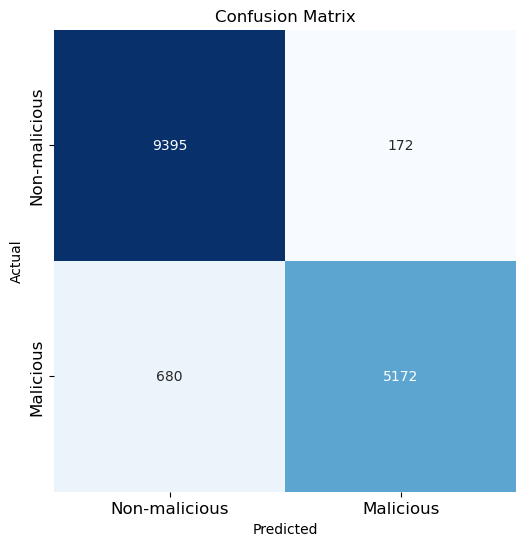

In [26]:
# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(np.arange(cm.shape[1]) + 0.5, labels=['Non-malicious', 'Malicious'], fontsize=12)
plt.yticks(np.arange(cm.shape[0]) + 0.5, labels=['Non-malicious', 'Malicious'], fontsize=12)
plt.show()

In [27]:
from plot_metric.functions import BinaryClassification as BC

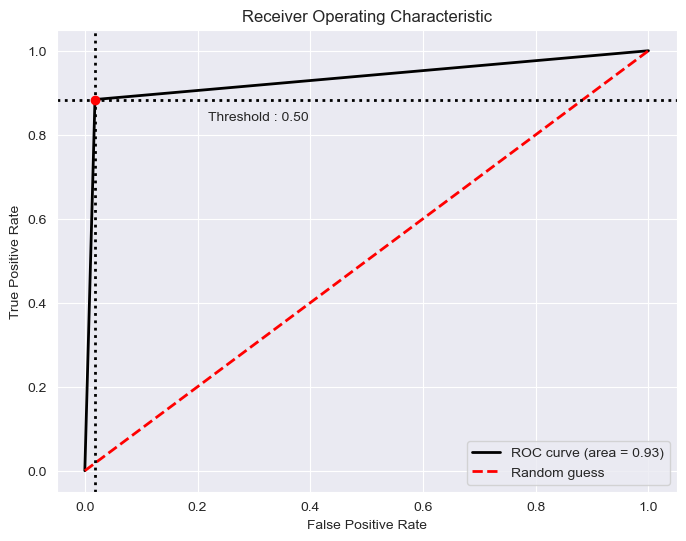

In [28]:
bc = BC(y_test, y_pred, labels=["y_test", "y_pred"])
# # plotting AOC-RUC Curve
plt.figure(figsize=(8,6))
bc.plot_roc_curve()
plt.show()

In [29]:
# Cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='accuracy')
print("Cross-validation Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))


Cross-validation Accuracy: 0.94 (+/- 0.00)
